In [3]:
# Objective of this project:
# Expectation
    # On the basis of text entered, a user receives Tags which are offered to him
    # These Tags are used to characterize the entered document
    # The mechanism should be as follows:
        # 1. Unsupervised method such as LDA (latent dirichlet allocation) to create topics
        # 2. These topics are docs considered the X
        # 3. A supervised RF-type method must make it possible to predict Tags
            # The Xs are the Topics obtained by LDA
            # There are Tags originally
    # It is necessary to develop metrics:
        # https://scikit-learn.org/stable/modules/model_evaluation.html
        # Use sckikilearn multilabel

# Source:
# SELECT Id, Body, Title, Tags FROM posts WHERE Id <50000 AND Score> = 5 AND Tags IS NOT NULL
# https://data.stackexchange.com/stackoverflow/query/edit/1288874    

# This Noteboook is the one corresponding to Notebook 1

# The structure of notebooks is as follows:
# Notebook 1
# - Text cleaning for X and y (includes univariate and multivariate analysis)
# - Extraction of all words from texts and titles to identify the 25 most used
# - Multilabel binarizer of y
# - Tf-idf of Xs
# - Univariate and multivariate analysis of Xs
# - Univariate and multivariate analysis of Ys, in particular via a PCA
# - Export my X and y in df format

# Notebook 2 vdef
# - Split train-test (2 collar for the X and 2 collar for the y)
# - LDA base train: Objective = avoid overfitting of Xs, obtained prediction of Xs via unsupervised method
# - From the LDA matrix: One vs Rest (Random Forest Classifier) ​​to predict the ys - OvR: because y = multilabel
        # predict rf / y_test which allows me to get a prediction matrix
        # ==> objective: predict y_test (avoid overfitting ys)
# Production of metrics (F1, Log Loss, Hamming loss)
# Based on a text (X),
    # predict main topics via lda
    # predict Tags (Ys) via OvR (RF)

import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter("ignore")

# Vérification of the version
import sklearn
sklearn.__version__

# 2. Load the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, nltk, spacy, gensim
from nltk.corpus import stopwords
from bs4 import BeautifulSoup


In [4]:
# Section 1: Cleaning up textual data to make it usable

In [5]:
# Step 1: import of data source
df = pd.read_csv("P6QueryResults4.csv", sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3869 entries, 0 to 3868
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      3869 non-null   int64 
 1   Body    3869 non-null   object
 2   Title   3869 non-null   object
 3   Tags    3869 non-null   object
dtypes: int64(1), object(3)
memory usage: 121.0+ KB


In [6]:
# Step 2: Creation of the material on which we will work

# Reminder: The objective is to Predict Tags, based on:
# The 'Body' and 'Title' fields which constitute the variable X
# From the 'Tags' field which constitutes the variable Y to predict
df['Text'] = df['Body'].astype(str) + df['Title'].astype(str)
df['Tags'] = df['Tags'].astype(str)
# df.info()

In [7]:
# 2.1 : Définition of X and y
X, y = df.Text, df.Tags

In [9]:
import nltk
nltk.download('stopwords')

# 3.2 Creation of a function that will normalize the texts
# Common functions used to standardize 'Text' and 'Tags'
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;?*]')
BAD_SYMBOLS_RE1 = re.compile('[^0-9a-z #+_-]') # 'VB.NET' becomes'vb.net'
STOPWORDS = list((stopwords.words('english')))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/safiurrehman/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# 2.2.1 Text with html (Text) tags
def text_prepare_WithSoup(text, join_symbol):
    """
        text: a string

        return: modified initial string
    """
    # Remove html tags
    text = BeautifulSoup(text,features="lxml").get_text()
    
    # Make uppercase lowercase
    text = text.lower()

    # Replace the symbols listed in the 'REPLACE_BY_SPACE_RE' function by a space
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text,)

    # Remove the symbols listed in the 'BAD_SYMBOLS_RE1' function
    text = re.sub(r'\s+', " ", text)

    # Remove stopwords from text
    text = f'{join_symbol}'.join(
        [i for i in text.split() if i not in STOPWORDS])

    return text

tests = ["<p> SQL Server - any equivalent of Excel's CHOOSE function VB.NET. ? * @ <p> ",
         "Berkeley-db How to free c++ memory vector<int> * arr? vb6"]
for test in tests:
    print(text_prepare_WithSoup(test, ' '))

sql server - equivalent excel's choose function vb.net.
berkeley-db free c++ memory vector arr vb6


In [11]:
# 2.2.2 Text without html tags (Tags)
BAD_SYMBOLS_RE2 = re.compile('[^0-9a-z .#+_-]') # Unlike 'BAD_SYMBOLS_RE2', here we keep the '.'
# 'VB.NET' becomes 'vb.net'
def text_prepare_NoSoup(text, join_symbol):
    """
        text: a string

        return: modified initial string
    """
    # Make uppercase lowercase
    text = text.lower()

    # Replace the symbols listed in the 'REPLACE_BY_SPACE_RE' function by a space
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text,)

    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(BAD_SYMBOLS_RE2, " ", text)
    text = re.sub(r'\s+', " ", text)

    # Remove stopwords from text
    text = f'{join_symbol}'.join(
        [i for i in text.split() if i not in STOPWORDS])

    return text
tests = ["<p> SQL Server - any equivalent of Excel's CHOOSE function VB.NET. ? * @ <p> ",
         "Berkeley-db How to free c++ memory vector<int> * arr? vb6"]

for test in tests:
    print(text_prepare_NoSoup(test, ' '))
# In this case, the html '<p>' tags remain but this is to demonstrate that as the Tags do not have any,
# then the beautiful soup function should NOT be activated.
# The result is as expected

p sql server - equivalent excel choose function vb.net. p
berkeley-db free c++ memory vector int arr vb6


In [12]:
# First transformation for 'Text' and 'Tags'
X_cleaned = [text_prepare_WithSoup(X, ' ') for X in X]

In [13]:
# Checking the Xs
# Originally, the data set 'Text' is as follows
X[50]

"<ul>\n<li>What's the optimal level of concurrency that the C++ implementation of BerkeleyDB can reasonably support?</li>\n<li>How many threads can I have hammering away at the DB before throughput starts to suffer because of resource contention?</li>\n</ul>\n\n<p>I've read the manual and know how to set the number of locks, lockers, database page size, etc. but I'd just like some advice from someone who has real-world experience with BDB concurrency.</p>\n\n<p>My application is pretty simple, I'll be doing gets and puts of records that are about 1KB each. No cursors, no deleting.</p>\nBerkeleyDB Concurrency"

In [14]:
X_cleaned[50]

"what's optimal level concurrency c++ implementation berkeleydb reasonably support many threads hammering away db throughput starts suffer resource contention i've read manual know set number locks lockers database page size etc. i'd like advice someone real-world experience bdb concurrency. application pretty simple i'll gets puts records 1kb each. cursors deleting. berkeleydb concurrency"

In [15]:
y_cleaned = [text_prepare_NoSoup(y, ' ') for y in y]

In [16]:
# Checking the y
# Originally, the data set 'Tag' is as follows
y[50:52]

50      <c++><berkeley-db>
51    <svn><collaboration>
Name: Tags, dtype: object

In [17]:
# First and last transformation of ys which mainly contains names
y_cleaned [2:5]

['c# .net datetime',
 'c# datetime time datediff relative-time-span',
 'html browser timezone user-agent timezone-offset']

In [18]:
# Section 2 : Choix des tags qui vont être conservés
# La liste des tags est trop importante pour faire un multilabel binarizer en l'état
# Il faut préalablement sélectionner les 25 tags les plus utilisés

In [19]:
#  Etape 1 : Compter le nb d'occurence de chaque Tag
# 1.1 Compte tous les mots et tokenisation

In [20]:
# Compte Tous les mots
all_text = ' '.join([text for text in y_cleaned])
print('Number of words in all_text:', len(all_text))

Number of words in all_text: 99561


In [21]:
# Tokenisation (sans transformation pour conserver c#, c++, etc.
# import SpaceTokenizer() de nltk 
from nltk.tokenize import SpaceTokenizer 
     
# Création de la variable de la Class SpaceTokenizer 
tk = SpaceTokenizer() 
     
# Utilisation de la méthode
tag_tokenized = tk.tokenize(all_text) 

# Vérification
print(tag_tokenized) 

['c#', 'floating-point', 'type-conversion', 'double', 'decimal', 'html', 'css', 'internet-explorer-7', 'c#', '.net', 'datetime', 'c#', 'datetime', 'time', 'datediff', 'relative-time-span', 'html', 'browser', 'timezone', 'user-agent', 'timezone-offset', '.net', 'math', 'c#', 'linq', 'web-services', '.net-3.5', 'mysql', 'database', 'binary-data', 'data-storage', 'performance', 'algorithm', 'language-agnostic', 'unix', 'pi', 'mysql', 'database', 'triggers', 'c++', 'c', 'sockets', 'mainframe', 'zos', 'arrays', 'actionscript-3', 'apache-flex', 'sql', 'sql-server', 'datatable', 'rdbms', 'c#', '.net', 'vb.net', 'timer', 'php', 'plugins', 'architecture', 'hook', 'html', 'forms', 'form-submit', 'submit-button', 'c#', 'linq', '.net-3.5', 'mime', 'file-type', 'office-2007', 'linq', '.net-3.5', 'ruby', 'rdoc', 'eclipse', 'svn', 'aptana', 'subclipse', 'apache-flex', 'actionscript-3', 'air', 'php', 'sql', 'database', 'flat-file', 'linux', 'winapi', 'visual-c++', 'unix', 'timer', 'svn', 'tortoisesvn'

In [22]:
# 1.2 Using the counter (most common) function

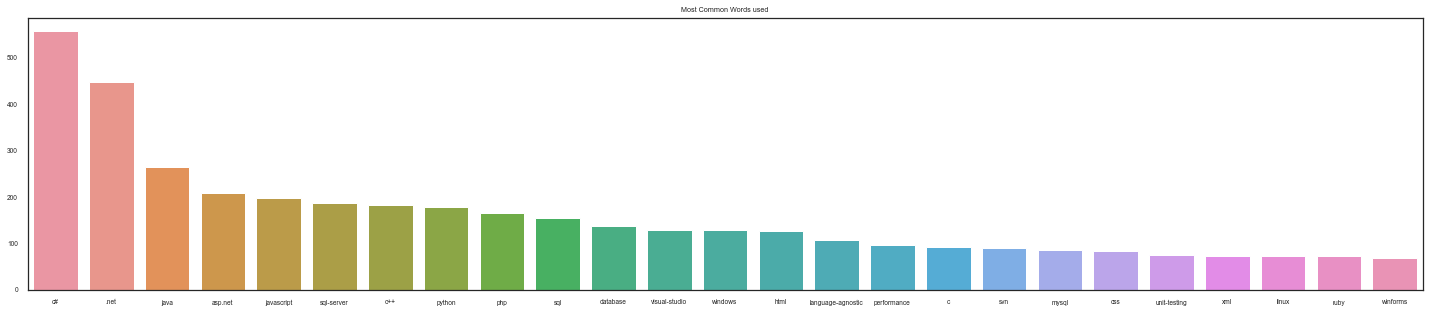

In [23]:
from collections import Counter
import seaborn as sns
eap_counts = Counter(tag_tokenized)
eap_common_words = [word[0] for word in eap_counts.most_common(25)]
eap_common_counts = [word[1] for word in eap_counts.most_common(25)]

sns.set(style="white", font_scale=0.6)
plt.figure(figsize=(25, 5))

sns.barplot(x=eap_common_words, y=eap_common_counts)
plt.title('Most Common Words used');

In [24]:
# Etape 2 : Sélectionner les 25 Tags ayant le plus grand nb d'occurences

In [25]:
from itertools import chain

# Dictionary of all tags from train corpus with their counts.
tags_counts = Counter(chain.from_iterable([i.split(",") for i in tag_tokenized]))

# Dictionary of all words from train corpus with their counts.
words_counts = Counter(chain.from_iterable([i.split(" ") for i in tag_tokenized]))

top_25_most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:25]
top_25_most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:25]

print(f"Top 25th most popular tags are: {','.join(tag for tag, _ in top_25_most_common_tags)}")

Top 25th most popular tags are: c#,.net,java,asp.net,javascript,sql-server,c++,python,php,sql,database,visual-studio,windows,html,language-agnostic,performance,c,svn,mysql,css,unit-testing,xml,linux,ruby,winforms


In [26]:
print('Liste des 25 mots avec leur fréquence: ',top_25_most_common_tags)
print("\n")
print ('Liste des 25 mots sans leur fréquence: ',eap_common_words)

Liste des 25 mots avec leur fréquence:  [('c#', 557), ('.net', 448), ('java', 265), ('asp.net', 208), ('javascript', 197), ('sql-server', 187), ('c++', 182), ('python', 178), ('php', 165), ('sql', 154), ('database', 137), ('visual-studio', 130), ('windows', 128), ('html', 126), ('language-agnostic', 107), ('performance', 97), ('c', 93), ('svn', 91), ('mysql', 85), ('css', 83), ('unit-testing', 75), ('xml', 74), ('linux', 73), ('ruby', 72), ('winforms', 69)]


Liste des 25 mots sans leur fréquence:  ['c#', '.net', 'java', 'asp.net', 'javascript', 'sql-server', 'c++', 'python', 'php', 'sql', 'database', 'visual-studio', 'windows', 'html', 'language-agnostic', 'performance', 'c', 'svn', 'mysql', 'css', 'unit-testing', 'xml', 'linux', 'ruby', 'winforms']


In [27]:
# Step 3: Delete from the total list of tags, the tags not kept
# (or keep only the selected Tags)

In [28]:
df_y_cleaned = pd.DataFrame(y_cleaned,columns=['AllTags'])
df_tag_cleaned = pd.DataFrame(top_25_most_common_tags,columns=['Good_tags','FreqTags'])
df_x_cleaned = pd.DataFrame(X_cleaned,columns=['content'])

In [29]:
print(df_y_cleaned.head(3))
print(df_tag_cleaned.head(3))
print(df_x_cleaned.head(3))

                                            AllTags
0  c# floating-point type-conversion double decimal
1                      html css internet-explorer-7
2                                  c# .net datetime
  Good_tags  FreqTags
0        c#       557
1      .net       448
2      java       265
                                             content
0  want use track-bar change form's opacity. code...
1  absolutely positioned div containing several c...
2  given datetime type representing person's birt...


In [30]:
# you must first separate the tags for each line and put them on a list:
df_y_cleaned["tags_list"] = df_y_cleaned["AllTags"].apply(lambda tag_string : tag_string.split(" ") ) 

In [31]:
df_y_cleaned

,AllTags,tags_list
0,c# floating-point type-conversion double decimal,"[c#, floating-point, type-conversion, double, ..."
1,html css internet-explorer-7,"[html, css, internet-explorer-7]"
2,c# .net datetime,"[c#, .net, datetime]"
3,c# datetime time datediff relative-time-span,"[c#, datetime, time, datediff, relative-time-s..."
4,html browser timezone user-agent timezone-offset,"[html, browser, timezone, user-agent, timezone..."
...,...,...
3864,.net garbage-collection,"[.net, garbage-collection]"
3865,excel vba,"[excel, vba]"
3866,html css cross-browser,"[html, css, cross-browser]"
3867,.net dll,"[.net, dll]"


In [32]:
# then, we put the tags we want to keep on a list: eap_common_words
# for the example we suppose that this list is on the variable "selected_tags": Good_tags

# to eliminate tags that we don't want:
df_y_cleaned["corrected_tags_list"] = df_y_cleaned["tags_list"].apply(
    lambda tags: [tag for tag in tags if tag in eap_common_words])

In [33]:
df_y_cleaned.head(5)

,AllTags,tags_list,corrected_tags_list
0,c# floating-point type-conversion double decimal,"[c#, floating-point, type-conversion, double, ...",[c#]
1,html css internet-explorer-7,"[html, css, internet-explorer-7]","[html, css]"
2,c# .net datetime,"[c#, .net, datetime]","[c#, .net]"
3,c# datetime time datediff relative-time-span,"[c#, datetime, time, datediff, relative-time-s...",[c#]
4,html browser timezone user-agent timezone-offset,"[html, browser, timezone, user-agent, timezone...",[html]


In [34]:
# Section 2: Binarization of ys (multilabel binarizer)
# As a reminder, we are configuring a multilabel and not a multiclass (one hot encoder)
    # multilabel: The car can be red, blue, black at the same time,
    # multiclass: the car can only be red, or black or blue: it's exclusive
# So you have to use multilabel binarizer
from sklearn.preprocessing import MultiLabelBinarizer

In [35]:
mlb = MultiLabelBinarizer()
df_y_mlb = pd.DataFrame(mlb.fit_transform(df_y_cleaned['corrected_tags_list']),columns=mlb.classes_)

In [36]:
df_y_mlb.head(3)

,.net,asp.net,c,c#,c++,css,database,html,java,javascript,...,python,ruby,sql,sql-server,svn,unit-testing,visual-studio,windows,winforms,xml
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
ColName_y = df_y_mlb.columns

In [38]:
print(ColName_y)

Index(['.net', 'asp.net', 'c', 'c#', 'c++', 'css', 'database', 'html', 'java',
       'javascript', 'language-agnostic', 'linux', 'mysql', 'performance',
       'php', 'python', 'ruby', 'sql', 'sql-server', 'svn', 'unit-testing',
       'visual-studio', 'windows', 'winforms', 'xml'],
      dtype='object')


In [39]:
# Section 3: Binarization of Xs (count vectorizer)

In [40]:
# Step 1: Converting textual data and numeric value of Xs
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_x = CountVectorizer(analyzer="word",
                             max_features=1500, # val testée pour gridsearch = 50, mais fails qn mm
                             # min_df=0.05,
                             max_df=0.9,
                             # stop_words=stopwords.words('english'),
                             # tokenizer = None,
                             preprocessor = None,
                             )
            
X = vectorizer_x.fit_transform(X_cleaned).toarray()
# We get the column names variable X
ColName_X = list(vectorizer_x.vocabulary_.keys())[:1500]
ColName_X[0:10]

['want',
 'use',
 'track',
 'bar',
 'change',
 'form',
 'code',
 'decimal',
 'value',
 'this']

In [41]:
# Step 2: Graphic visualization of words used in Text
tfidf_vocab_x = vectorizer_x.get_feature_names()
# Sum up the counts of each vocabulary word
dist_x = np.sum(X, axis=0)
# For each, print the vocabulary word and the number of times it
# appears in the training set
for tag, count in zip(tfidf_vocab_x, dist_x):
    print(count, tag)

61 00
31 000
37 0000
127 10
94 100
35 11
53 12
33 15
58 20
36 2000
46 2003
163 2005
48 2007
227 2008
29 28
50 30
30 31
69 32
70 50
63 64
29 64bit
42 ability
393 able
57 abstract
47 accept
36 accepted
286 access
34 accessing
31 accomplish
35 according
49 account
127 across
115 action
34 actions
45 active
73 actual
207 actually
347 add
88 added
84 adding
32 additional
138 address
30 admin
35 advantages
64 advice
37 again
50 ago
108 ajax
37 alert
100 algorithm
34 algorithms
32 all
137 allow
48 allowed
58 allows
56 almost
55 along
161 already
513 also
37 alternative
44 alternatives
70 although
176 always
61 amount
48 analysis
262 another
224 answer
108 answers
85 anybody
596 anyone
216 anything
58 anyway
217 apache
122 api
355 app
41 appear
59 appears
35 append
881 application
64 applicationfilterchain
205 applications
52 apply
64 appreciated
151 approach
43 approaches
52 appropriate
90 apps
30 architecture
51 area
37 argument
47 arguments
206 around
242 array
41 arrays
34 article
38 artic

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
X_cleaned_count=Counter(X_cleaned)

# From my clean file, I create a list associating word and number of times it has been used
list_of_word_x =list(map(list, zip(tfidf_vocab_x, dist_x)))
# Verification
list_of_word_x[0:2]

[['00', 61], ['000', 31]]

In [43]:
# Sort by frequency
# 1 function
def sortSecond(val): 
    return val[1] 
# 2 Sort
sorted_list_of_word_x = sorted(list_of_word_x,key=sortSecond,reverse=True)
# 3 Verification
sorted_list_of_word_x [0:2]

[['like', 1819], ['using', 1731]]

In [44]:
# Transformation of this list of words in df
df_sorted_list_of_words_x= pd.DataFrame(sorted_list_of_word_x,columns=['Mots', 'NbMots'])
# Verification
# Display the 25th word of the site so the value corresponds to 'NbMots'
print(df_sorted_list_of_words_x.iloc[25,0:2]) # The 25th word on the list has been used xx times
print(df_sorted_list_of_words_x.iloc[0,0:2]) # The 1st word in the list has been used xx times
print(df_sorted_list_of_words_x.head(3))

Mots      sql
NbMots    726
Name: 25, dtype: object
Mots      like
NbMots    1819
Name: 0, dtype: object
    Mots  NbMots
0   like    1819
1  using    1731
2    use    1633


In [45]:
# Display the 25th word of the site so the value corresponds to 'NbMots'
# To automate the display of the 25 most frequently used words of 'Text', we create a variable x_word-25
X_word_25 = df_sorted_list_of_words_x.iloc[24,1:2]
X_word_25.astype(int)
# print(x_word_25['NbMots'][0])
X_word_25[0]

731

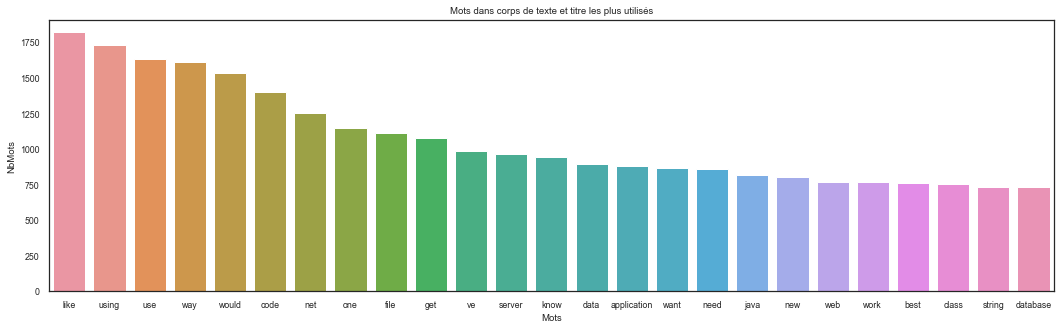

In [46]:
# Selection of number of words (first 25 of the list) without entry of amount (by a variable)

df_sorted_list_of_words_selected_x = df_sorted_list_of_words_x[(df_sorted_list_of_words_x['NbMots'] >=X_word_25[0])]
# sorted_list_y1 = sorted_list_y1[(sorted_list_y1['FreqencyTags'] >=y_word_25_Tag1[0])]

# Display graph bar chart
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", font_scale=0.8)
plt.figure(figsize=(18, 5))
sns.barplot(x="Mots", y="NbMots",
            data=df_sorted_list_of_words_selected_x,
            )
plt.title('Mots dans corps de texte et titre les plus utilisés')
plt.show()

In [47]:
# Section 4: Univariate exploration of Xs via TF-IDF process:
# This is not the method that will be used, but it allows a better understanding of the distribution of the X
# TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [48]:
# 4.1 Preliminary split test train specific to this section
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, df_y_mlb, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2708, 1500)
(1161, 1500)
(2708, 25)
(1161, 25)


In [49]:
X_train[0:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
y_train[0:2]

,.net,asp.net,c,c#,c++,css,database,html,java,javascript,...,python,ruby,sql,sql-server,svn,unit-testing,visual-studio,windows,winforms,xml
1053,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3212,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [51]:
# 4.2 text classification and tag prediction
# Beforehand, we do a GridSearchCV to search for parameters to optimize
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

param_gridRF = {"max_depth": [3, 5],  # Maximum number of levels in tree
                "min_samples_split": [3, 10],# Minimum number of samples required to split a node
                }

rfc = RandomForestClassifier(random_state=42, oob_score=True)

In [52]:
# 4.3 GridSearchCV :
modelrfc = GridSearchCV(rfc,
                        param_gridRF,
                        n_jobs=-1,
                        cv=5)

modelrfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=42,
                                   

In [53]:
best_rfc_model = modelrfc.best_estimator_

In [54]:
# 4.4 Viewing the best settings
print("Best Model's Params: ", modelrfc.best_params_)

# Log Likelihood Score
print("Best score ", modelrfc.best_score_)

Best Model's Params:  {'max_depth': 3, 'min_samples_split': 3}
Best score  0.2643962594893971


In [55]:
y_pred = modelrfc.predict(X_test)

In [56]:
print('Shape de y_pred: ',y_pred.shape)
print('Shape de y_test: ',y_test.shape)

Shape de y_pred:  (1161, 25)
Shape de y_test:  (1161, 25)


In [57]:
# 4.5: Development of performance metrics
from sklearn.metrics import f1_score 
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss

print('log loss:{:.4f}'.format(log_loss(y_test, y_pred)))
# print("\n")
print('1-hamming_loss:{:.4f}'.format(1-hamming_loss(y_test, y_pred)))

log loss:3.2632
1-hamming_loss:0.9594


In [58]:
# Section 5: Mutivariate exploration of X and y via RFC process and k-meam for visualization of clusters:

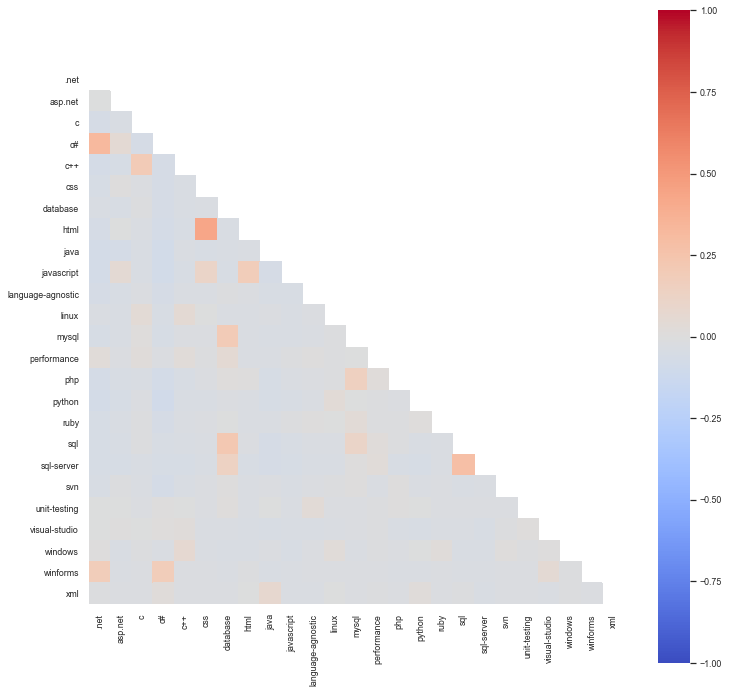

In [59]:
# 5.1 Correlation matrix of y
fig, ax = plt.subplots(figsize=(12,12)) 
matrix = np.triu(df_y_mlb.corr())
sns.heatmap(df_y_mlb.corr(), annot= False, fmt='.1g',vmin=-1, vmax=1,center=0,cmap='coolwarm', 
            square=True, mask=matrix)
plt.show()

In [60]:
# Section 6: Univariate and multivariate exploration of ys via PCA
use : df_y_mlb
#number of observations
n = df.shape[0] 
 
#number of variables 
p = df.shape[1] 

In [61]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(df_y_mlb)
y_scaled = std_scale.transform(df_y_mlb)

In [62]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=5)
pca.fit(y_scaled)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [63]:
# If I accumulate the explained var of the 2 1st PCAs
print(pca.explained_variance_ratio_.cumsum())

[0.06745103 0.13317168 0.19195572 0.24106214 0.28657861]


In [64]:
# Visualization of points on the 2 main axes
# project X onto the principal components
import matplotlib.pyplot as plt
y_projected = pca.transform(y_scaled)

# Display the number of points
print (y_projected.shape)

(3869, 5)


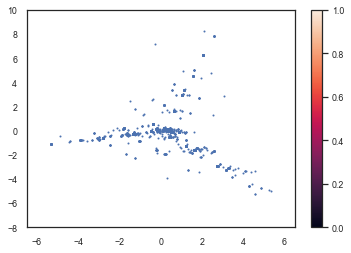

In [65]:
# Display the plot of ys
plt.scatter(y_projected[:, 0], y_projected[:, 1],s=1,
    # colorer en utilisant la variable 'Rank'
    c=df_y_mlb.get('C#')) # If there is something, it takes, if not, it does not return anything,
    # avoid making a mistake

plt.xlim([-6.5, 6.5])
plt.ylim([-8, 10])
plt.colorbar()
# We visualize the points which have more weight: those close to 0.0 of the vertical bar
plt.show()

(-0.6, 0.6)

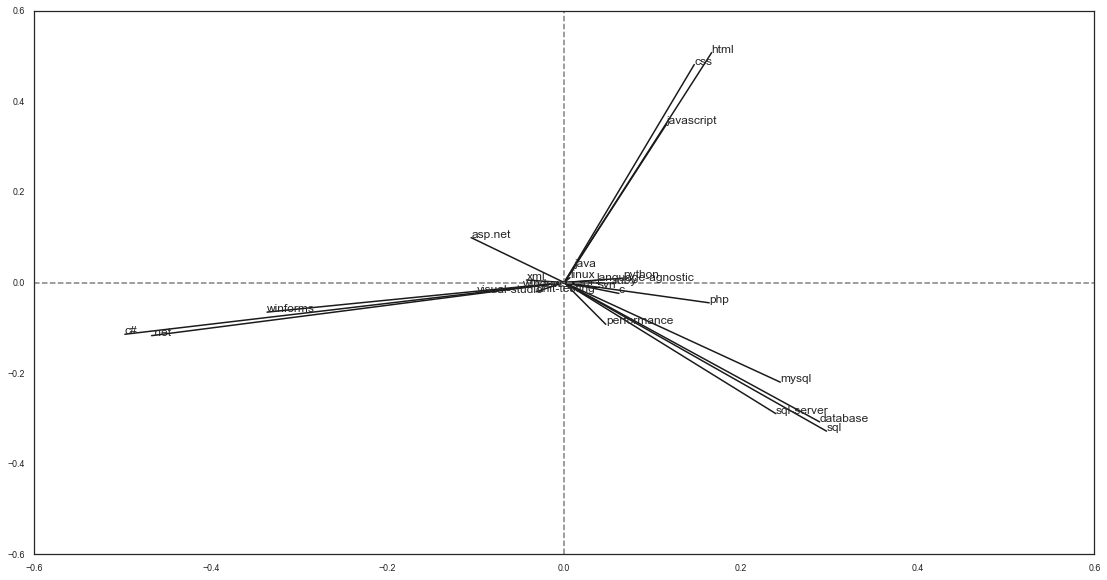

In [66]:
# Graph dimensions optimized for P6QueryResults5.csv
pcs = pca.components_
plt.figure(figsize=(19,10))


for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Display a segment from the origin to point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Display the name (data.columns [i]) of the performance
    plt.text(x, y, df_y_mlb.columns[i], fontsize='12')

# Display a horizontal line y = 0
plt.plot([-0.6, 0.6], [0, 0], color='grey', ls='--')

# Display a vertical line x = 0
plt.plot([0, 0], [-0.6, 0.6], color='grey', ls='--')

plt.xlim([-0.6, 0.6])
plt.ylim([-0.6, 0.6])
# We observe that a 3-branch star distribution of Tags

In [67]:
# Section 7: Export of the df obtained in complete format, to keep the ref of the questions (otherwise we lose the link)
df_X = pd.DataFrame(X,columns=[ColName_X])

In [68]:
df_y_vctzd_tagsclnd = pd.merge(df_y_cleaned, df_y_mlb, right_index=True, left_index=True)
df_y_vctzd_tagsclnd.head(5)

,AllTags,tags_list,corrected_tags_list,.net,asp.net,c,c#,c++,css,database,...,python,ruby,sql,sql-server,svn,unit-testing,visual-studio,windows,winforms,xml
0,c# floating-point type-conversion double decimal,"[c#, floating-point, type-conversion, double, ...",[c#],0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,html css internet-explorer-7,"[html, css, internet-explorer-7]","[html, css]",0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,c# .net datetime,"[c#, .net, datetime]","[c#, .net]",1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,c# datetime time datediff relative-time-span,"[c#, datetime, time, datediff, relative-time-s...",[c#],0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,html browser timezone user-agent timezone-offset,"[html, browser, timezone, user-agent, timezone...",[html],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# We keep the results
import csv
df_X.to_csv('P6_df_X_vctzd_idf.csv')
df_x_cleaned.to_csv('P6_df_X.csv')
df_y_cleaned.to_csv('P6_df_y.csv')
df_y_mlb.to_csv('P6_df_y_vctzd.csv')
df_y_vctzd_tagsclnd.to_csv('P6_df_y_vctzd_tagclnd.csv')

In [67]:
# END: This notebook allowed
    # 1. To explore the X and y data
    # 2.to determine the best method of cleaning and vectorization
        # For X: count vectorizer
        # to Multilabel Binarozer to keep texts
    # 3.to test the tf-idf and Rf method
    # 4. To end with a PCA analysis of the y in order to visualize their relationships.
        # PCA with binarized data being less efficient than LDA
    # 5.To build up the files that will serve as a basic tain and test for the next Notebook
# The next Notebook will implement the LDA and RF (One Vs Rest) method.